## Regression for Diabetes Dataset

### 

> for TeX typesetting plese use [Markdown All in One](https://marketplace.visualstudio.com/items?itemName=yzhang.markdown-all-in-one) extension. 

In [2]:
import numpy as np 
import pandas as pd

# plotting
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

# keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 

# utils
from sklearn.datasets import load_diabetes
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# metrics
from sklearn.metrics import confusion_matrix, roc_curve

sns.set_theme(style="white")
sns.set(font_scale=1.5, rc={'text.usetex' : True})

In [23]:
def make_nn_regressor(input_dim):
    """ 
    Neural network based regressor,
    Args:
        input_dim: (int) the size of the input vectors
    """
    model = Sequential()
    layers = [
        Dense(128, input_dim=input_dim, activation='relu'),
        Dense(64, activation='relu'),
        Dense(3, activation='linear'),
    ]

    for l in layers:
        model.add(l)
    
    # compile the keras model
    model.compile(
        loss='mse', 
        optimizer='adam', 
        metrics=['accuracy'])

    return model

In [44]:
dataset = load_diabetes(as_frame=True)
data = dataset['data']
target = dataset['target']
data['target'] = target

In [63]:
data.describe()


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-3.634285e-16,1.308343e-16,-8.045349e-16,1.281655e-16,-8.835316e-17,1.327024e-16,-4.574646e-16,3.777301e-16,-3.830854e-16,-3.412882e-16,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01,346.000000


In [64]:
target.describe()

count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: target, dtype: float64

In [53]:
fig = px.scatter_3d(
                    data, 
                    x='age', 
                    y='bmi', 
                    z='s2', 
                    color='target'
                    )
fig.show()

In [67]:
X, Y = data.values[:, :10], target.values
# scale Y 
scaler_y = StandardScaler()
scaler_y.fit(Y.reshape(-1, 1))
Ysc = scaler_y.transform(Y.reshape(-1, 1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Ysc, test_size=0.33, random_state=25)

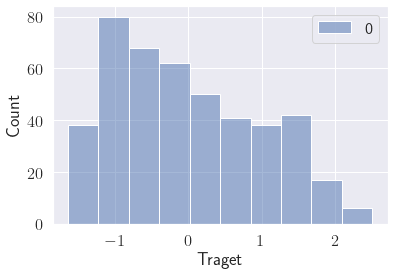

In [69]:
sns.histplot(Ysc)
plt.xlabel('Traget')
plt.show()